In [ ]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook
!pip install fairseq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 34.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.3/285.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fairseq: filename=fairseq-0.12.2-cp310-cp310-linux_x86_64.whl size=11291813 sha256=70923096f4f5a88144460d75061c430367fe65911eb61a49530ca4e20dd2fa55
  Stored in directory: /root/.cache/pip/wheels/e4/35/55/9c66f65ec7c83fd6fbc2b9502a0ac81b2448a1196159dacc32
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl

In [ ]:
# Initializing random seed for consistency
random.seed(42)
torch_generator = torch.Generator().manual_seed(2147483647)

# Enforcing deterministic behavior in GPU operations for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Determining device based on availability of CUDA
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using Device:", device)

Using Device: cuda:0


In [ ]:
# Defining preprocessing operations for CIFAR-10 dataset
CIFAR10_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # CIFAR-10 images are RGB
])

# Downloading and splitting the CIFAR-10 training dataset
cifar10_train_dataset = torchvision.datasets.CIFAR10(root='/data/torchvision/CIFAR10/training', train=True, download=True, transform=CIFAR10_transforms)
training_data, validation_data = torch.utils.data.random_split(cifar10_train_dataset, [40000, 10000])  # Adjusted training-validation split

# Downloading the CIFAR-10 test dataset
test_data = torchvision.datasets.CIFAR10(root='/data/torchvision/CIFAR10/testing', train=False, download=True, transform=CIFAR10_transforms)

# Defining data loaders
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_data, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:15<00:00, 11150821.03it/s]


Extracting /data/torchvision/CIFAR10/training/cifar-10-python.tar.gz to /data/torchvision/CIFAR10/training


100%|██████████| 170498071/170498071 [00:15<00:00, 11211421.27it/s]


Extracting /data/torchvision/CIFAR10/testing/cifar-10-python.tar.gz to /data/torchvision/CIFAR10/testing


---------Training Data Loader---------
40000
torch.Size([32, 3, 32, 32])
torch.Size([32])
---------Validation Data Loader---------
10000
torch.Size([32, 3, 32, 32])
torch.Size([32])
---------Test Data Loader---------
10000
torch.Size([32, 3, 32, 32])
torch.Size([32])


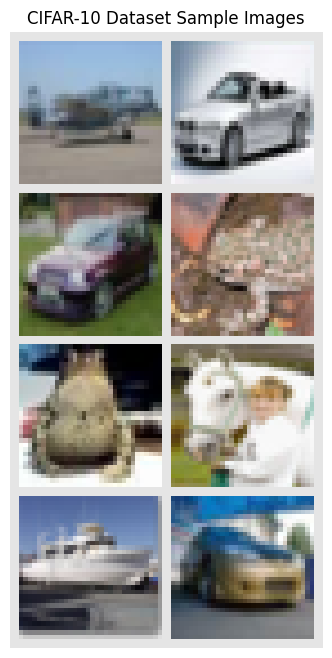

In [ ]:
def verify_dataset_dimensions(loader, description):
    print('---------{}---------'.format(description))
    print(len(loader.dataset))
    for images, labels in loader:
        print(images.shape)
        print(labels.shape)
        break

verify_dataset_dimensions(train_loader, 'Training Data Loader')
verify_dataset_dimensions(validation_loader, 'Validation Data Loader')
verify_dataset_dimensions(test_loader, 'Test Data Loader')


import matplotlib.pyplot as plt
import torch
import torchvision


# Displaying sample images from the CIFAR-10 dataset
num_example_images = 8
sample_images = torch.stack([validation_data[idx][0] for idx in range(num_example_images)], dim=0)
image_grid = torchvision.utils.make_grid(sample_images, nrow=2, normalize=True, pad_value=0.9)
image_grid = image_grid.permute(1, 2, 0)  # Rearranging the dimensions for matplotlib

plt.figure(figsize=(8, 8))
plt.title("CIFAR-10 Dataset Sample Images")
plt.imshow(image_grid)
plt.axis("off")
plt.show()
plt.close()


# Hyperparameters
image_size = 32       # CIFAR-10 images are 32x32
embed_dim = 256
hidden_dim = embed_dim * 3
num_heads = 8
num_layers = 6
patch_size = 4       # Size of the patches (4x4 patches for 32x32 images)
num_patches = (image_size // patch_size) ** 2
num_channels = 3     # CIFAR-10 uses RGB images
num_classes = 10
attn_type = 1
dropout = 0.2

In [ ]:
def convert_to_patches(x, patch_size, flatten_channels=True):
    """
    Transforming the given image into patches.
    Args:
        x: Tensor representing the image [B, C, H, W]
        patch_size: Size of each patch
        flatten_channels: Flattens the patches into feature vectors if True
    """
    B, C, H, W = x.shape  # [B, C, H, W], CIFAR-10 [B, 3, 32, 32]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)  # [B, C, H', p_H, W', p_W], CIFAR-10 [B, 3, H/4, 4, W/4, 4] for patch_size=4
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], CIFAR-10 [B, H/4, W/4, 3, 4, 4]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], CIFAR-10 [B, H/4*W/4, 3, 4, 4]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], CIFAR-10 [B, H/4*W/4, 3*4*4]
    return x


In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

# code source : https://github.com/facebookresearch/fairseq/blob/main/examples/linformer/linformer_src/modules/multihead_linear_attention.py

import math
from typing import Dict, Optional, Tuple
import time

import torch
import torch.nn.functional as F
from fairseq import utils
from fairseq.incremental_decoding_utils import with_incremental_state
from fairseq.modules.quant_noise import quant_noise
from torch import Tensor, nn
from torch.nn import Parameter


@with_incremental_state
class MultiheadLinearAttention(nn.Module):
    """Multi-headed linformer attention.

    Projects the key and values down to the compressed dimension, before computing self-attention.

    See "Linformer: Self-Attention with Linear Complexity" for more details.
    """

    def __init__(
        self,
        embed_dim,
        num_heads,
        kdim=None,
        vdim=None,
        dropout=0.0,
        bias=True,
        add_bias_kv=False,
        add_zero_attn=False,
        self_attention=False,
        encoder_decoder_attention=False,
        q_noise=0.0,
        qn_block_size=8,
        compressed=1,
        max_seq_len=256,
        shared_kv_compressed=0,
        shared_compress_layer=None,
        freeze_compress=0,
    ):
        super().__init__()
        self.embed_dim = int(embed_dim)
        self.kdim = int(kdim) if kdim is not None else self.embed_dim
        self.vdim = int(vdim) if vdim is not None else self.embed_dim
        self.qkv_same_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = int(embed_dim // num_heads)  # changed

        assert (
            self.head_dim * num_heads == self.embed_dim
        ), "embed_dim must be divisible by num_heads"
        self.scaling = self.head_dim ** -0.5

        self.self_attention = self_attention
        self.encoder_decoder_attention = encoder_decoder_attention

        assert not self.self_attention or self.qkv_same_dim, (
            "Self-attention requires query, key and " "value to be of the same size"
        )

        self.k_proj = quant_noise(
            nn.Linear(self.kdim, embed_dim, bias=bias), q_noise, qn_block_size
        )
        self.v_proj = quant_noise(
            nn.Linear(self.vdim, embed_dim, bias=bias), q_noise, qn_block_size
        )
        self.q_proj = quant_noise(
            nn.Linear(embed_dim, embed_dim, bias=bias), q_noise, qn_block_size
        )

        # used for compress sequence to subsequence
        if shared_compress_layer is None:
            self.compress_seq_len = int(max_seq_len // compressed)
            self.compress_k = nn.Linear(max_seq_len, self.compress_seq_len, bias=False)
            if shared_kv_compressed == 0:
                self.compress_v = nn.Linear(
                    max_seq_len, self.compress_seq_len, bias=False
                )
            self.layerwise_sharing = False
        else:
            self.compress_k = shared_compress_layer
            if shared_kv_compressed == 0:
                self.compress_v = shared_compress_layer
            self.layerwise_sharing = True
        self.shared_kv_compressed = shared_kv_compressed

        self.out_proj = quant_noise(
            nn.Linear(embed_dim, embed_dim, bias=bias), q_noise, qn_block_size
        )

        if add_bias_kv:
            self.bias_k = Parameter(torch.Tensor(1, 1, embed_dim))
            self.bias_v = Parameter(torch.Tensor(1, 1, embed_dim))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self.reset_parameters()

        if freeze_compress == 1:
            self.compress_k.weight.requires_grad = False
            if shared_kv_compressed == 0:
                self.compress_v.weight.requires_grad = False

        self.onnx_trace = False

    def prepare_for_onnx_export_(self):
        self.onnx_trace = True

    def reset_parameters(self):
        if self.qkv_same_dim:
            # Empirically observed the convergence to be much better with
            # the scaled initialization
            nn.init.xavier_uniform_(self.k_proj.weight, gain=1 / math.sqrt(2))
            nn.init.xavier_uniform_(self.v_proj.weight, gain=1 / math.sqrt(2))
            nn.init.xavier_uniform_(self.q_proj.weight, gain=1 / math.sqrt(2))
            if (
                not self.layerwise_sharing
            ):  # otherwise, we already initialize the parameters
                nn.init.xavier_uniform_(self.compress_k.weight, gain=1 / math.sqrt(2))
                if self.shared_kv_compressed == 0:
                    nn.init.xavier_uniform_(
                        self.compress_v.weight, gain=1 / math.sqrt(2)
                    )
        else:
            nn.init.xavier_uniform_(self.k_proj.weight)
            nn.init.xavier_uniform_(self.v_proj.weight)
            nn.init.xavier_uniform_(self.q_proj.weight)
            if (
                not self.layerwise_sharing
            ):  # otherwise, we already initialize the parameters
                nn.init.xavier_uniform_(self.compress_k.weight)
                if self.shared_kv_compressed == 0:
                    nn.init.xavier_uniform_(self.compress_v.weight)

        nn.init.xavier_uniform_(self.out_proj.weight)
        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0.0)
        if self.bias_k is not None:
            nn.init.xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            nn.init.xavier_normal_(self.bias_v)

    def forward(
        self,
        query,
        key: Optional[Tensor],
        value: Optional[Tensor],
        key_padding_mask: Optional[Tensor] = None,
        incremental_state: Optional[Dict[str, Dict[str, Optional[Tensor]]]] = None,
        need_weights: bool = True,
        static_kv: bool = False,
        attn_mask: Optional[Tensor] = None,
        before_softmax: bool = False,
        need_head_weights: bool = False,
    ) -> Tuple[Tensor, Optional[Tensor]]:
        """Input shape: Time x Batch x Channel

        Args:
            key_padding_mask (ByteTensor, optional): mask to exclude
                keys that are pads, of shape `(batch, src_len)`, where
                padding elements are indicated by 1s.
            need_weights (bool, optional): return the attention weights,
                averaged over heads (default: False).
            attn_mask (ByteTensor, optional): typically used to
                implement causal attention, where the mask prevents the
                attention from looking forward in time (default: None).
            before_softmax (bool, optional): return the raw attention
                weights and values before the attention softmax.
            need_head_weights (bool, optional): return the attention
                weights for each head. Implies *need_weights*. Default:
                return the average attention weights over all heads.
        """
        if need_head_weights:
            need_weights = True

        tgt_len, bsz, embed_dim = query.size()
        assert embed_dim == self.embed_dim
        assert list(query.size()) == [tgt_len, bsz, embed_dim]

        if incremental_state is not None:
            saved_state = self._get_input_buffer(incremental_state)
            if saved_state is not None and "prev_key" in saved_state:
                # previous time steps are cached - no need to recompute
                # key and value if they are static
                if static_kv:
                    assert self.encoder_decoder_attention and not self.self_attention
                    key = value = None
        else:
            saved_state = None

        if self.self_attention:
            q = self.q_proj(query)

            k_input = query.permute(1, 2, 0).contiguous()  # B * C * T
            k_input = (
                F.linear(k_input, self.compress_k.weight[:, 0:tgt_len])
                .permute(2, 0, 1)
                .contiguous()
            )
            k = self.k_proj(k_input)

            v_input = query.permute(1, 2, 0).contiguous()  # B * C * T
            if self.shared_kv_compressed == 0:
                v_input = (
                    F.linear(v_input, self.compress_v.weight[:, 0:tgt_len])
                    .permute(2, 0, 1)
                    .contiguous()
                )
            if self.shared_kv_compressed == 1:  # use shared kv compressed linear layer
                v_input = (
                    F.linear(v_input, self.compress_k.weight[:, 0:tgt_len])
                    .permute(2, 0, 1)
                    .contiguous()
                )
            v = self.v_proj(v_input)
        elif self.encoder_decoder_attention:
            # encoder-decoder attention
            q = self.q_proj(query)
            if key is None:
                assert value is None
                k = v = None
            else:
                k = self.k_proj(key)
                v = self.v_proj(key)

        else:
            assert key is not None and value is not None
            q = self.q_proj(query)
            k = self.k_proj(key)
            v = self.v_proj(value)
        q *= self.scaling

        if self.bias_k is not None:
            assert self.bias_v is not None
            k = torch.cat([k, self.bias_k.repeat(1, bsz, 1)])
            v = torch.cat([v, self.bias_v.repeat(1, bsz, 1)])
            if attn_mask is not None:
                attn_mask = torch.cat(
                    [attn_mask, attn_mask.new_zeros(attn_mask.size(0), 1)], dim=1
                )
            if key_padding_mask is not None:
                key_padding_mask = torch.cat(
                    [
                        key_padding_mask,
                        key_padding_mask.new_zeros(key_padding_mask.size(0), 1),
                    ],
                    dim=1,
                )

        q = (
            q.contiguous()
            .view(tgt_len, bsz * self.num_heads, self.head_dim)
            .transpose(0, 1)
        )
        if k is not None:
            k = (
                k.contiguous()
                .view(-1, bsz * self.num_heads, self.head_dim)
                .transpose(0, 1)
            )
        if v is not None:
            v = (
                v.contiguous()
                .view(-1, bsz * self.num_heads, self.head_dim)
                .transpose(0, 1)
            )

        if saved_state is not None:
            # saved states are stored with shape (bsz, num_heads, seq_len, head_dim)
            if "prev_key" in saved_state:
                _prev_key = saved_state["prev_key"]
                assert _prev_key is not None
                prev_key = _prev_key.view(bsz * self.num_heads, -1, self.head_dim)
                if static_kv:
                    k = prev_key
                else:
                    assert k is not None
                    k = torch.cat([prev_key, k], dim=1)
            if "prev_value" in saved_state:
                _prev_value = saved_state["prev_value"]
                assert _prev_value is not None
                prev_value = _prev_value.view(bsz * self.num_heads, -1, self.head_dim)
                if static_kv:
                    v = prev_value
                else:
                    assert v is not None
                    v = torch.cat([prev_value, v], dim=1)
            prev_key_padding_mask: Optional[Tensor] = None
            if "prev_key_padding_mask" in saved_state:
                prev_key_padding_mask = saved_state["prev_key_padding_mask"]
            assert k is not None and v is not None
            key_padding_mask = MultiheadLinearAttention._append_prev_key_padding_mask(
                key_padding_mask=key_padding_mask,
                prev_key_padding_mask=prev_key_padding_mask,
                batch_size=bsz,
                src_len=k.size(1),
                static_kv=static_kv,
            )

            saved_state["prev_key"] = k.view(bsz, self.num_heads, -1, self.head_dim)
            saved_state["prev_value"] = v.view(bsz, self.num_heads, -1, self.head_dim)
            saved_state["prev_key_padding_mask"] = key_padding_mask
            # In this branch incremental_state is never None
            assert incremental_state is not None
            incremental_state = self._set_input_buffer(incremental_state, saved_state)
        assert k is not None
        src_len = k.size(1)

        if self.add_zero_attn:
            assert v is not None
            src_len += 1
            k = torch.cat([k, k.new_zeros((k.size(0), 1) + k.size()[2:])], dim=1)
            v = torch.cat([v, v.new_zeros((v.size(0), 1) + v.size()[2:])], dim=1)
            if attn_mask is not None:
                attn_mask = torch.cat(
                    [attn_mask, attn_mask.new_zeros(attn_mask.size(0), 1)], dim=1
                )

        attn_weights = torch.bmm(q, k.transpose(1, 2))
        attn_weights = MultiheadLinearAttention.apply_sparse_mask(
            attn_weights, tgt_len, src_len, bsz
        )

        assert list(attn_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(0)
            if self.onnx_trace:
                attn_mask = attn_mask.repeat(attn_weights.size(0), 1, 1)
            attn_weights += attn_mask

        if before_softmax:
            return attn_weights, v

        attn_weights_float = utils.softmax(
            attn_weights, dim=-1, onnx_trace=self.onnx_trace
        )
        attn_weights = attn_weights_float.type_as(attn_weights)
        attn_probs = F.dropout(
            attn_weights,
            p=self.dropout,
            training=self.training,
        )
        assert v is not None
        attn = torch.bmm(attn_probs, v)
        assert list(attn.size()) == [bsz * self.num_heads, tgt_len, self.head_dim]
        if self.onnx_trace and attn.size(1) == 1:
            # when ONNX tracing a single decoder step (sequence length == 1)
            # the transpose is a no-op copy before view, thus unnecessary
            attn = attn.contiguous().view(tgt_len, bsz, embed_dim)
        else:
            attn = attn.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
        attn = self.out_proj(attn)
        attn_weights: Optional[Tensor] = None
        if need_weights:
            attn_weights = attn_weights_float.view(
                bsz, self.num_heads, tgt_len, src_len
            ).transpose(1, 0)
            if not need_head_weights:
                # average attention weights over heads
                attn_weights = attn_weights.mean(dim=0)

        return attn, attn_weights

    @staticmethod
    def _append_prev_key_padding_mask(
        key_padding_mask: Optional[Tensor],
        prev_key_padding_mask: Optional[Tensor],
        batch_size: int,
        src_len: int,
        static_kv: bool,
    ) -> Optional[Tensor]:
        # saved key padding masks have shape (bsz, seq_len)
        if prev_key_padding_mask is not None and static_kv:
            new_key_padding_mask = prev_key_padding_mask
        elif prev_key_padding_mask is not None and key_padding_mask is not None:
            new_key_padding_mask = torch.cat(
                [prev_key_padding_mask.float(), key_padding_mask.float()], dim=1
            )
        # During incremental decoding, as the padding token enters and
        # leaves the frame, there will be a time when prev or current
        # is None
        elif prev_key_padding_mask is not None:
            filler = torch.zeros(
                (batch_size, src_len - prev_key_padding_mask.size(1)),
                device=prev_key_padding_mask.device,
            )
            new_key_padding_mask = torch.cat(
                [prev_key_padding_mask.float(), filler.float()], dim=1
            )
        elif key_padding_mask is not None:
            filler = torch.zeros(
                (batch_size, src_len - key_padding_mask.size(1)),
                device=key_padding_mask.device,
            )
            new_key_padding_mask = torch.cat(
                [filler.float(), key_padding_mask.float()], dim=1
            )
        else:
            new_key_padding_mask = prev_key_padding_mask
        return new_key_padding_mask

    @torch.jit.export
    def reorder_incremental_state(
        self,
        incremental_state: Dict[str, Dict[str, Optional[Tensor]]],
        new_order: Tensor,
    ):
        """Reorder buffered internal state (for incremental generation)."""
        input_buffer = self._get_input_buffer(incremental_state)
        if input_buffer is not None:
            for k in input_buffer.keys():
                input_buffer_k = input_buffer[k]
                if input_buffer_k is not None:
                    if self.encoder_decoder_attention and input_buffer_k.size(
                        0
                    ) == new_order.size(0):
                        break
                    input_buffer[k] = input_buffer_k.index_select(0, new_order)
            incremental_state = self._set_input_buffer(incremental_state, input_buffer)
        return incremental_state

    def _get_input_buffer(
        self, incremental_state: Optional[Dict[str, Dict[str, Optional[Tensor]]]]
    ) -> Dict[str, Optional[Tensor]]:
        result = self.get_incremental_state(incremental_state, "attn_state")
        if result is not None:
            return result
        else:
            empty_result: Dict[str, Optional[Tensor]] = {}
            return empty_result

    def _set_input_buffer(
        self,
        incremental_state: Dict[str, Dict[str, Optional[Tensor]]],
        buffer: Dict[str, Optional[Tensor]],
    ):
        return self.set_incremental_state(incremental_state, "attn_state", buffer)

    def apply_sparse_mask(attn_weights, tgt_len: int, src_len: int, bsz: int):
        return attn_weights

    def upgrade_state_dict_named(self, state_dict, name):
        prefix = name + "." if name != "" else ""
        items_to_add = {}
        keys_to_remove = []
        for k in state_dict.keys():
            if k.endswith(prefix + "in_proj_weight"):
                # in_proj_weight used to be q + k + v with same dimensions
                dim = int(state_dict[k].shape[0] / 3)
                items_to_add[prefix + "q_proj.weight"] = state_dict[k][:dim]
                items_to_add[prefix + "k_proj.weight"] = state_dict[k][dim : 2 * dim]
                items_to_add[prefix + "v_proj.weight"] = state_dict[k][2 * dim :]

                keys_to_remove.append(k)

                k_bias = prefix + "in_proj_bias"
                if k_bias in state_dict.keys():
                    dim = int(state_dict[k].shape[0] / 3)
                    items_to_add[prefix + "q_proj.bias"] = state_dict[k_bias][:dim]
                    items_to_add[prefix + "k_proj.bias"] = state_dict[k_bias][
                        dim : 2 * dim
                    ]
                    items_to_add[prefix + "v_proj.bias"] = state_dict[k_bias][2 * dim :]

                    keys_to_remove.append(prefix + "in_proj_bias")

        for k in keys_to_remove:
            del state_dict[k]

        for key, value in items_to_add.items():
            state_dict[key] = value

In [ ]:
class LinearSelfAttentionLayer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, kdim=None, vdim=None, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = MultiheadLinearAttention(embed_dim, num_heads, kdim=kdim, vdim=vdim)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [ ]:
class LinformerMain(nn.Module):
    def __init__(self,
                 embed_dim=256,
                 hidden_dim=embed_dim * 3,
                 num_heads=8,
                 num_layers=6,
                 patch_size=4,  # Size of the patches
                 num_channels=3,  # CIFAR-10 uses RGB images
                 num_classes=10,
                 num_patches=64,
                 attn_type=0,
                 dropout=0.0):

        super().__init__()

        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2


        # Layers
        self.input_layer = nn.Linear(num_channels * (patch_size ** 2), embed_dim)
        self.transformer = nn.Sequential(
            *(LinearSelfAttentionLayer(embed_dim, hidden_dim, num_heads, dropout=dropout)
              if attn_type == 1 else
              AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout)
              for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + self.num_patches, embed_dim))

    def forward(self, x):
        # Preprocessing input
        x = convert_to_patches(x, self.patch_size)        # x.shape ---> batch, num_patches, (patch_size**2)


        B, T, _ = x.shape
        x = self.input_layer(x)                     # x.shape ---> batch, num_patches, embed_dim


        # Adding CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)        # x.shape ---> batch, num_patches+1, embed_dim
        x = x + self.pos_embedding[:, : T + 1]      # x.shape ---> batch, num_patches+1, embed_dim

        # Applying Transformer
        x = self.dropout(x)
        x = x.transpose(0, 1)                       # x.shape ---> num_patches+1, batch, embed_dim

        x = self.transformer(x)                     # x.shape ---> num_patches+1, batch, embed_dim

        # Performing classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [ ]:
model = LinformerMain(
                 embed_dim=256,
                 hidden_dim=embed_dim * 3,
                 num_heads=8,
                 num_layers=6,
                 patch_size=4,  # Size of the patches
                 num_channels=3,  # CIFAR-10 uses RGB images
                 num_classes=10,
                 attn_type=0,
                 dropout=0.0,)

# Transferring to GPU
model.to(device)
model_restore = None #'/content/model_20230712_211204_0'
if model_restore is not None and os.path.exists(model_restore):
  model.load_state_dict(torch.load(model_restore))
  model.restored = True

In [ ]:
# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimzer
model_optimizer = optim.Adam(model.parameters(), lr=0.0003)
# Scheduler for learning rate
model_scheduler = optim.lr_scheduler.MultiStepLR(model_optimizer,
                                            milestones=[100, 150], gamma=0.1)


train_losses, validation_losses, train_accuracies, validation_accuracies, epoch_durations = [], [], [], [], []

best_validation_loss = 1_000_000
best_epoch = 0
num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()  # Start time of the epoch

    # Initializing metrics for training
    running_train_loss, running_train_accuracy, total_train_samples = 0.0, 0, 0

    for imgs, labels in train_loader:
        model.train(True)
        imgs, labels = imgs.to(device), labels.to(device)
        model_optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        loss.backward()
        model_optimizer.step()

        # Accumulating training loss and accuracy
        running_train_loss += loss.item()
        _, predicted = torch.max(preds.data, 1)
        running_train_accuracy += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = running_train_accuracy / total_train_samples

    # Initializing metrics for validation
    running_validation_loss, running_validation_accuracy, total_validation_samples = 0.0, 0, 0

    model.eval()
    with torch.no_grad():
        for vdata in validation_loader:
            validation_inputs, validation_labels = vdata[0].to(device), vdata[1].to(device)
            validation_outputs = model(validation_inputs)
            validation_loss = loss_fn(validation_outputs, validation_labels)

            # Accumulating validation loss and accuracy
            running_validation_loss += validation_loss.item()
            _, predicted = torch.max(validation_outputs.data, 1)
            running_validation_accuracy += (predicted == validation_labels).sum().item()
            total_validation_samples += validation_labels.size(0)

    avg_validation_loss = running_validation_loss / len(validation_loader)
    val_accuracy = running_validation_accuracy / total_validation_samples

    # Saving best model
    if avg_validation_loss < best_validation_loss:
        best_validation_loss = avg_validation_loss
        best_epoch = epoch + 1
        model_path = '/model_LinformerMain_Cifar10_{}.pt'.format(epoch+1)
        torch.save(model.state_dict(), model_path)

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Calculating the duration of the epoch

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    validation_losses.append(avg_validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(val_accuracy)
    epoch_durations.append(epoch_duration)

    # Printing metrics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_validation_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}')
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_duration:.2f} seconds")

Epoch 1/10, Training Loss: 1.7069978580474854, Validation Loss: 1.4909391525073554, Training Accuracy: 0.381225, Validation Accuracy: 0.4523
Epoch 1/10 took 44.24 seconds
Epoch 2/10, Training Loss: 1.394915254163742, Validation Loss: 1.333848395667518, Training Accuracy: 0.495875, Validation Accuracy: 0.523
Epoch 2/10 took 45.43 seconds
Epoch 3/10, Training Loss: 1.2652617025852204, Validation Loss: 1.2651729625634873, Training Accuracy: 0.544625, Validation Accuracy: 0.5458
Epoch 3/10 took 44.66 seconds
Epoch 4/10, Training Loss: 1.1718773750305176, Validation Loss: 1.244346404418397, Training Accuracy: 0.5789, Validation Accuracy: 0.5489
Epoch 4/10 took 44.50 seconds
Epoch 5/10, Training Loss: 1.090559337949753, Validation Loss: 1.1741994558431852, Training Accuracy: 0.608975, Validation Accuracy: 0.5782
Epoch 5/10 took 45.25 seconds
Epoch 6/10, Training Loss: 1.009362509393692, Validation Loss: 1.172163889050103, Training Accuracy: 0.637325, Validation Accuracy: 0.5851
Epoch 6/10 to

In [ ]:
model.eval()
acc_total = 0
with torch.no_grad():
  for imgs, labels in tqdm_notebook(test_loader):

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc = acc_total.item()/len(test_loader.dataset)
print('Accuracy on test set = '+str(acc))

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set = 0.6066


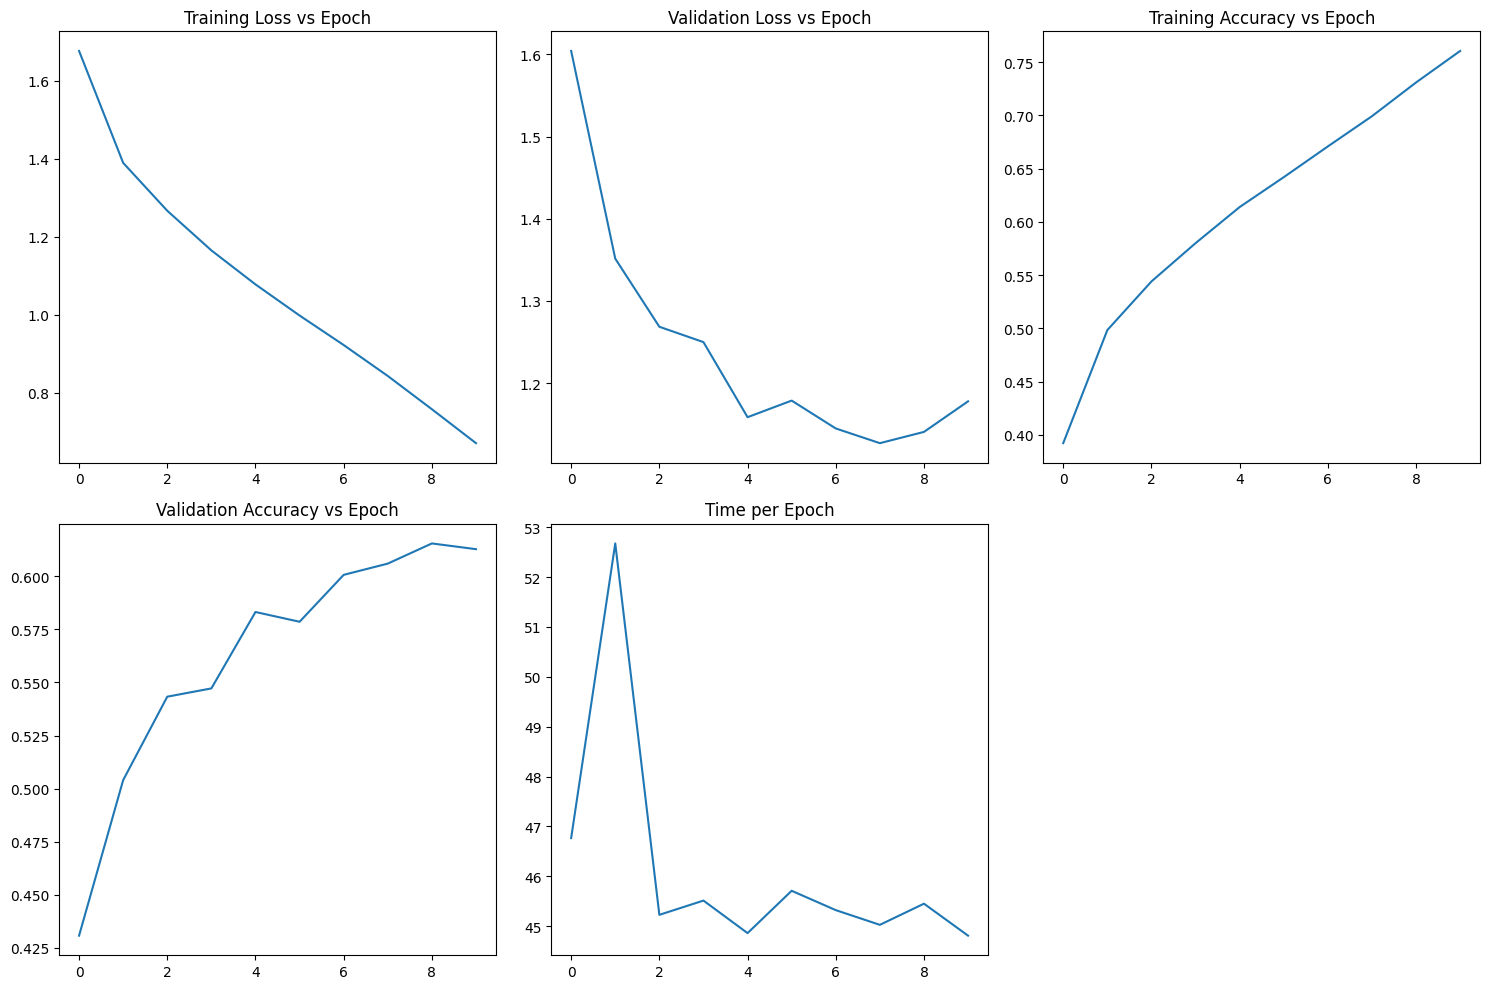

Best Epoch: 8


In [ ]:
# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss vs Epoch")

axs[0, 1].plot(validation_losses)
axs[0, 1].set_title("Validation Loss vs Epoch")

axs[0, 2].plot(train_accuracies)
axs[0, 2].set_title("Training Accuracy vs Epoch")

axs[1, 0].plot(validation_accuracies)
axs[1, 0].set_title("Validation Accuracy vs Epoch")

axs[1, 1].plot(epoch_durations)
axs[1, 1].set_title("Time per Epoch")

# Hiding the last blank subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()


print(f'Best Epoch: {best_epoch}')

In [ ]:
MNIST_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.Grayscale(num_output_channels=3),  # Correctly converting to 3-channel grayscale
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:


# Downloading and splitting the MNIST training dataset
mnist_train_dataset = torchvision.datasets.MNIST(root='./data/MNIST/training', train=True, download=True, transform=MNIST_transforms)
mnist_training_data, mnist_validation_data = torch.utils.data.random_split(mnist_train_dataset, [50000, 10000])  # Adjusted training-validation split

# Downloading the MNIST test dataset
mnist_test_data = torchvision.datasets.MNIST(root='./data/MNIST/testing', train=False, download=True, transform=MNIST_transforms)

# Defining data loaders for MNIST
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_training_data, batch_size=32, shuffle=True)
mnist_validation_loader = torch.utils.data.DataLoader(dataset=mnist_validation_data, batch_size=32, shuffle=False)
mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_data, batch_size=32, shuffle=False)

In [ ]:

model.to(device)  # Ensuring the model is on the correct device

# Fetching a single batch from the MNIST loader
single_batch_imgs, single_batch_labels = next(iter(mnist_train_loader))
single_batch_imgs = single_batch_imgs.to(device)

# Running the model on this single batch
model.eval()  # Setting the model to evaluation mode
with torch.no_grad():
    try:
        output = model(single_batch_imgs)
        print("Output shape:", output.shape)
    except RuntimeError as e:
        print("Error encountered:", e)


Shape after convert_to_patches: torch.Size([32, 64, 48])
Shape after input_layer: torch.Size([32, 64, 256])
Output shape: torch.Size([32, 10])


In [ ]:
import time

# Loss Function for MNIST
mnist_loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer for MNIST (same as CIFAR-10)
mnist_optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Scheduler for learning rate for MNIST (same as CIFAR-10)
mnist_scheduler = optim.lr_scheduler.MultiStepLR(mnist_optimizer, milestones=[100, 150], gamma=0.1)

# Training loop for MNIST with speed tests
train_losses, val_losses, train_accuracies, val_accuracies, epoch_durations = [], [], [], [], []

best_mnist_validation_loss = 1_000_000
best_epoch = 0
mnist_num_epochs = 20

total_time = 0

for epoch in range(mnist_num_epochs):
    start_time = time.time()
    model.train(True)

    running_train_loss, running_train_accuracy, total_train_samples = 0.0, 0, 0
    for imgs, labels in mnist_train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        mnist_optimizer.zero_grad()
        preds = model(imgs)
        loss = mnist_loss_fn(preds, labels)
        loss.backward()
        mnist_optimizer.step()

        # For training accuracy
        with torch.no_grad():
            total_train_samples += labels.size(0)
            _, predicted = torch.max(preds.data, 1)
            running_train_accuracy += (predicted == labels).sum().item()
        running_train_loss += loss.item()

    mnist_scheduler.step()
    running_mnist_validation_loss, running_mnist_validation_accuracy, total_val_samples = 0.0, 0, 0

    model.eval()
    with torch.no_grad():
        for vdata in mnist_validation_loader:
            validation_inputs, validation_labels = vdata[0].to(device), vdata[1].to(device)
            validation_outputs = model(validation_inputs)
            validation_loss = mnist_loss_fn(validation_outputs, validation_labels)

            total_val_samples += validation_labels.size(0)
            _, predicted = torch.max(validation_outputs.data, 1)
            running_mnist_validation_accuracy += (predicted == validation_labels).sum().item()
            running_mnist_validation_loss += validation_loss.item()

    # Calculating average losses and accuracies
    avg_train_loss = running_train_loss / len(mnist_train_loader)
    avg_validation_loss = running_mnist_validation_loss / len(mnist_validation_loader)
    train_accuracy = running_train_accuracy / total_train_samples
    validation_accuracy = running_mnist_validation_accuracy / total_val_samples

    # Storing metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_validation_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{mnist_num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_validation_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')

    if avg_validation_loss < best_mnist_validation_loss:
        best_mnist_validation_loss = avg_validation_loss
        best_epoch = epoch + 1
        mnist_model_path = f'/model_LinformerMain_MNIST_{epoch+1}.pt'
        torch.save(model.state_dict(), mnist_model_path)

    end_time = time.time()
    epoch_duration = end_time - start_time
    epoch_durations.append(epoch_duration)
    total_time += epoch_duration

    print(f"Epoch {epoch+1}/{mnist_num_epochs} took {epoch_duration:.2f} seconds")

# Calculating and printing average metrics
avg_epoch_duration = total_time / mnist_num_epochs
avg_training_loss = sum(train_losses) / len(train_losses)
avg_training_accuracy = sum(train_accuracies) / len(train_accuracies)
avg_validation_loss = sum(val_losses) / len(val_losses)
avg_validation_accuracy = sum(val_accuracies) / len(val_accuracies)

print(f'Average epoch duration: {avg_epoch_duration:.2f} seconds')
print(f'Average training loss: {avg_training_loss:.4f}')
print(f'Average training accuracy: {avg_training_accuracy:.4f}')
print(f'Average validation loss: {avg_validation_loss:.4f}')
print(f'Average validation accuracy: {avg_validation_accuracy:.4f}')



Epoch 1/20, Training Loss: 0.09084001790791135, Validation Loss: 0.1086495971506515, Training Accuracy: 0.97108, Validation Accuracy: 0.9649
Epoch 1/20 took 65.41 seconds
Epoch 2/20, Training Loss: 0.0757194285758283, Validation Loss: 0.09404478923822292, Training Accuracy: 0.97554, Validation Accuracy: 0.9712
Epoch 2/20 took 66.56 seconds
Epoch 3/20, Training Loss: 0.06468562865807805, Validation Loss: 0.07795061846933188, Training Accuracy: 0.97868, Validation Accuracy: 0.9752
Epoch 3/20 took 80.31 seconds
Epoch 4/20, Training Loss: 0.05981343186872172, Validation Loss: 0.07883106559156455, Training Accuracy: 0.98092, Validation Accuracy: 0.9754
Epoch 4/20 took 70.61 seconds
Epoch 5/20, Training Loss: 0.05447427616833774, Validation Loss: 0.0782874898863034, Training Accuracy: 0.98194, Validation Accuracy: 0.9741
Epoch 5/20 took 74.24 seconds
Epoch 6/20, Training Loss: 0.04722325391920703, Validation Loss: 0.08370755430137643, Training Accuracy: 0.98492, Validation Accuracy: 0.9745
E

In [ ]:
# Testing on MNIST
model.eval()
mnist_acc_total = 0
with torch.no_grad():
    for imgs, labels in mnist_test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        pred_cls = preds.data.max(1)[1]
        mnist_acc_total += pred_cls.eq(labels.data).cpu().sum()

mnist_acc = mnist_acc_total.item() / len(mnist_test_loader.dataset)
print(f'Accuracy on MNIST test set = {mnist_acc}')

Accuracy on MNIST test set = 0.9847


Best Epoch: 11


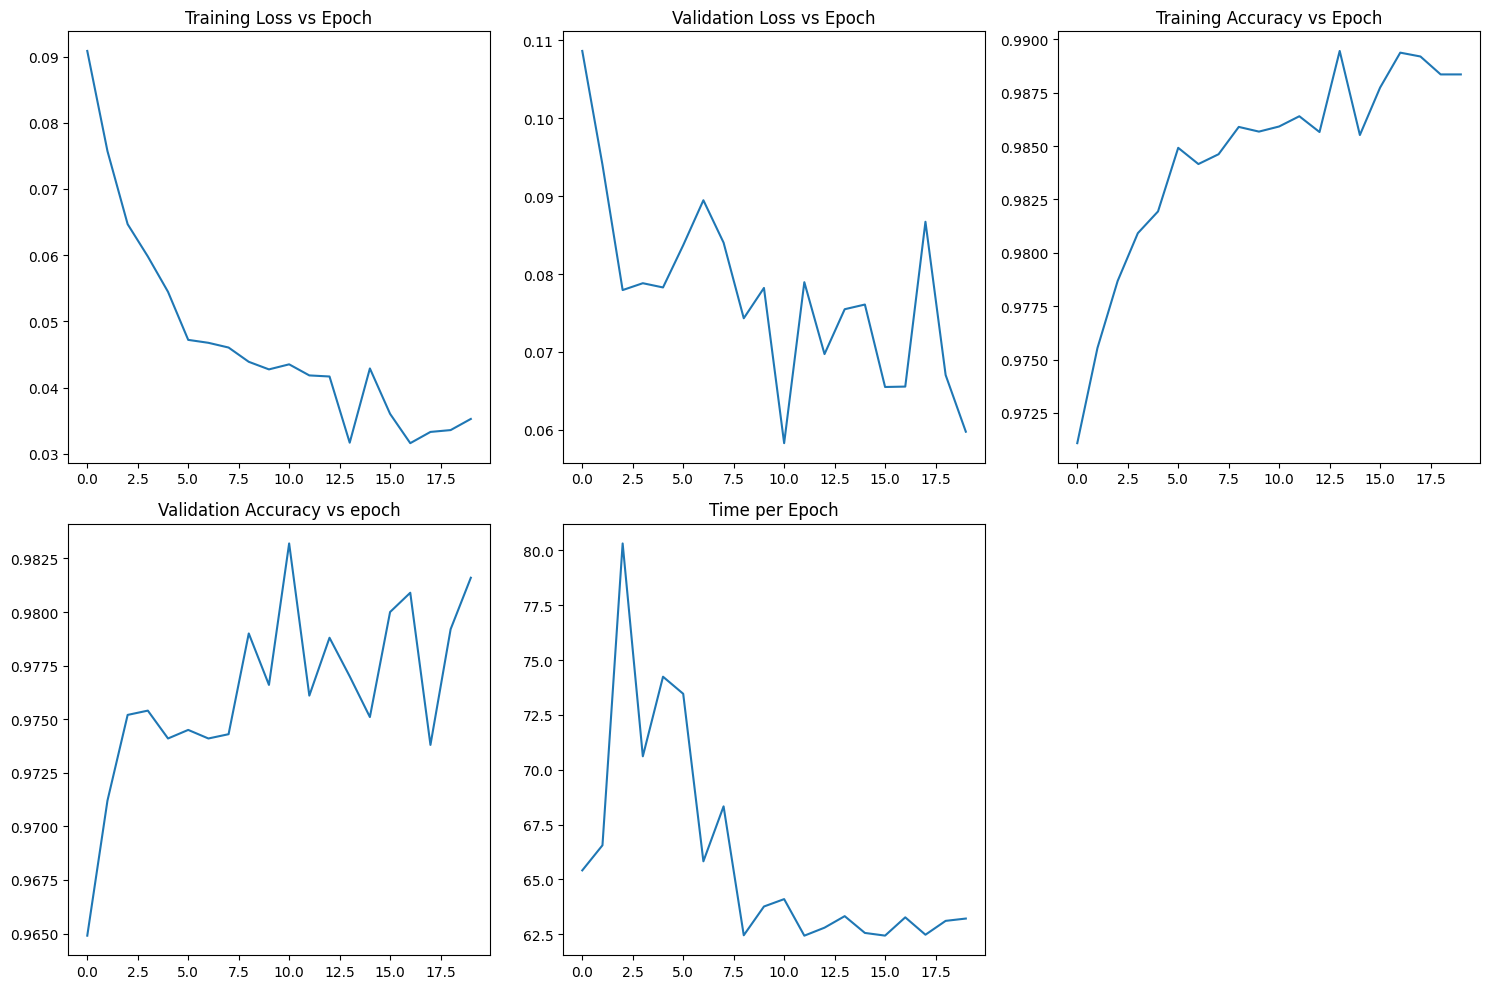

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss vs Epoch")

axs[0, 1].plot(val_losses)

axs[0, 1].set_title("Validation Loss vs Epoch")

axs[0, 2].plot(train_accuracies)
axs[0, 2].set_title("Training Accuracy vs Epoch")

axs[1, 0].plot(val_accuracies)
axs[1, 0].set_title("Validation Accuracy vs epoch")

axs[1, 1].plot(epoch_durations)
axs[1, 1].set_title("Time per Epoch")


# Hiding the last subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show

print(f'Best Epoch: {best_epoch}')